In [21]:
import pandas as pd
import numpy as np
from glob import glob
from sys import path
from tqdm.auto import tqdm

path.append("..")

from src.utils.plot import plot_categorical_distribution
from src.utils.data_preparation import (
    split_data_into_sessions,
    apply_filter,
    decompose_signal,
    segment_eda_data,
)

# early pre-processing
session_data_path: str = (
    "/Users/leonardoalchieri/Datasets/LinoData/APSYNC/Meta/Presentation_StartEndTime.csv"
)
eda_data_path: str = "/Users/leonardoalchieri/Datasets/LinoData/APSYNC/Data"
audience_survey_path: str = (
    "/Users/leonardoalchieri/Datasets/LinoData/APSYNC/Meta/Surveys_Audience.csv"
)
presenter_survey_path: str = (
    "/Users/leonardoalchieri/Datasets/LinoData/APSYNC/Meta/Surveys_Presenter.csv"
)

In [22]:
# data loading

session_data = pd.read_csv(session_data_path)
session_data["Start"] = session_data["Start"].apply(pd.to_datetime)
session_data["End"] = session_data["End"].apply(pd.to_datetime)

eda_datas = glob(f"{eda_data_path}/*/*/EDA-*.csv")
users: list[str] = list(set([val.split("/")[7] for val in eda_datas]))
eda_data = {tuple(file.split("/")[7:9]): pd.read_csv(file, header=None).values.reshape(-1) for file in eda_datas}

audience_survey = pd.read_csv(audience_survey_path)
presented_survey = pd.read_csv(presenter_survey_path)

In [23]:
processed_dict = {}
current_user: str = ""
session_dict: dict[str, pd.DataFrame] = {}
for key, val in eda_data.items():
    user, session = key
    if user != current_user:
        session_dict = {}
    current_user = user
    session_dict.update(split_data_into_sessions(val, session_data))
    processed_dict[user] = session_dict

In [24]:
audience_survey

,Audience,Presentation,Engagement,PresenterEngagement,Immersion,Enjoyment,Participants
0,S001,P1-RB,3,6,3,5,S001_All_P1-RB
1,S001,P1-DB,3,6,3,5,S001_All_P1-DB
2,S001,P2,3,3,4,4,S001_All_P2
3,S001,P3,5,6,3,6,S001_All_P3
4,S001,P4,4,6,4,5,S001_All_P4
...,...,...,...,...,...,...,...
76,S015,P13,4,4,4,4,S015_All_P13
77,S015,P16,6,5,4,5,S015_All_P16
78,S015,P21,3,5,4,4,S015_All_P21
79,S015,P22,7,6,3,7,S015_All_P22


In [25]:
# adding labels to the data

assert (
    len(audience_survey)
    == audience_survey[["Audience", "Presentation"]]
    .apply(lambda x: f"{x['Audience']}_{x['Presentation']}", axis=1)
    .nunique()
)

for _, (user, session) in audience_survey[["Audience", "Presentation"]].iterrows():
    engagement, immersion, enjoyment = audience_survey[
        (audience_survey["Audience"] == user)
        & (audience_survey["Presentation"] == session)
    ][["Engagement", "Immersion", "Enjoyment"]].values[0]
    processed_dict[user][session].attrs["audience_survey"] = {
        "engagement": engagement,
        "immersion": immersion,
        "enjoyment": enjoyment,
    }

In [26]:
cutoff_frequency = 0.4  # should not be changed, used like this by Elena Di Lascio
butterworth_order = 1  # should not be changed, used like this by Elena Di Lascio


filtered_data = {
    user: {
        session: apply_filter(
            data=data,
            cutoff_frequency=cutoff_frequency,
            butterworth_order=butterworth_order,
        )
        for session, data in user_dict.items()
    }
    for user, user_dict in processed_dict.items()
}

In [27]:
decomposed_data = {
    user: {
        session: decompose_signal(
            data=data,
        )
        for session, data in user_dict.items()
    }
    for user, user_dict in tqdm(filtered_data.items())
}

  0%|          | 0/27 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0: -2.5739e+02 -2.5754e+02  1e+03  3e+01  1e+00
 1: -2.6408e+02 -4.1403e+02  2e+02  5e+00  2e-01
 2: -2.6844e+02 -2.9556e+02  3e+01  7e-01  3e-02
 3: -2.6906e+02 -2.7232e+02  3e+00  7e-02  3e-03
 4: -2.6923e+02 -2.6958e+02  3e-01  9e-04  4e-05
 5: -2.6941e+02 -2.6950e+02  9e-02  2e-04  9e-06
 6: -2.6945e+02 -2.6948e+02  3e-02  8e-06  3e-07
 7: -2.6946e+02 -2.6947e+02  8e-03  7e-07  3e-08
 8: -2.6946e+02 -2.6946e+02  1e-03  7e-08  3e-09
 9: -2.6946e+02 -2.6946e+02  2e-04  1e-08  4e-10
10: -2.6946e+02 -2.6946e+02  4e-05  1e-09  4e-11
11: -2.6946e+02 -2.6946e+02  8e-06  2e-10  8e-12
12: -2.6946e+02 -2.6946e+02  2e-06  5e-11  2e-12
13: -2.6946e+02 -2.6946e+02  4e-07  1e-12  6e-14
14: -2.6946e+02 -2.6946e+02  4e-08  2e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.7179e+01 -7.2692e+01  1e+03  4e+01  3e+00
 1: -1.1723e+02 -3.1898e+02  3e+02  9e+00  6e-01
 2: -1.4305e+02 -2.6092e+02  1e+02  3e+00  2e-0

In [ ]:
segmented_data = []
engagement_labels = []
immersion_labels = []
enjoyment_labels = []
groups = []
for user, user_dict in decomposed_data.items():
    for session, session_data in user_dict.items():
        if "audience_survey" not in session_data.attrs:
            print(f"Skipping {(user, session)}")
            continue
        (
            current_segments,
            current_engagements,
            current_immersion,
            current_enjoyment,
            segmented_groups,
        ) = segment_eda_data(session_data, user, segment_length=10)
        segmented_data.extend(current_segments)
        engagement_labels.extend(current_engagements)
        immersion_labels.extend(current_immersion)
        enjoyment_labels.extend(current_enjoyment)
        groups.extend(segmented_groups)

Skipping ('P4', 'KEYNOTE')
Skipping ('P4', 'P1-RB')
Skipping ('P4', 'P1-DB')
Skipping ('P4', 'P2')
Skipping ('P4', 'P3')
Skipping ('P4', 'P4')
Skipping ('P4', 'P5')
Skipping ('P4', 'P6')
Skipping ('P4', 'P7')
Skipping ('P4', 'P8')
Skipping ('P4', 'P9')
Skipping ('P4', 'P15')
Skipping ('P3', 'KEYNOTE')
Skipping ('P3', 'P1-RB')
Skipping ('P3', 'P1-DB')
Skipping ('P3', 'P2')
Skipping ('P3', 'P3')
Skipping ('P3', 'P4')
Skipping ('P3', 'P5')
Skipping ('P3', 'P6')
Skipping ('P3', 'P15')
Skipping ('P2', 'KEYNOTE')
Skipping ('P2', 'P1-RB')
Skipping ('P2', 'P1-DB')
Skipping ('P2', 'P2')
Skipping ('P2', 'P3')
Skipping ('P2', 'P4')
Skipping ('P2', 'P5')
Skipping ('P2', 'P6')
Skipping ('P2', 'P15')
Skipping ('P5', 'KEYNOTE')
Skipping ('P5', 'P1-RB')
Skipping ('P5', 'P1-DB')
Skipping ('P5', 'P2')
Skipping ('P5', 'P3')
Skipping ('P5', 'P4')
Skipping ('P5', 'P5')
Skipping ('P5', 'P15')
Skipping ('P21', 'P18')
Skipping ('P21', 'P19')
Skipping ('P21', 'P20')
Skipping ('P21', 'P21')
Skipping ('P21', 'P2

In [31]:
segmented_data.shape

(530, 40, 3)

In [30]:
segmented_data = np.stack(segmented_data, axis=0)
engagement_labels = np.stack(engagement_labels, axis=0)
engagement_labels_binary = (engagement_labels  > 4).astype(int)
immersion_labels = np.stack(immersion_labels, axis=0)
immersion_labels_binary = (immersion_labels > 3).astype(int)
enjoyment_labels = np.stack(enjoyment_labels, axis=0)
enjoyment_labels_binary = (enjoyment_labels > 4).astype(int)
groups = np.stack(groups, axis=0)

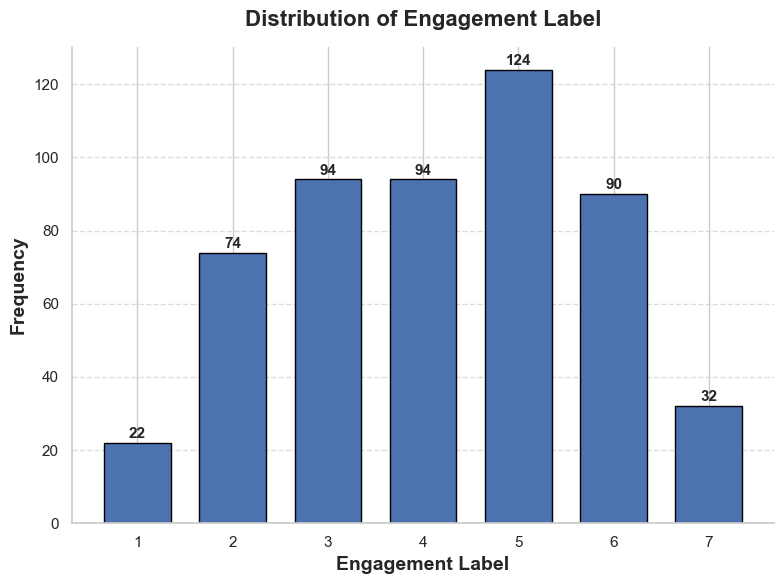

In [10]:
plot_categorical_distribution(
    engagement_labels,
    label_name="Engagement Label",
    use_latex=False,
)

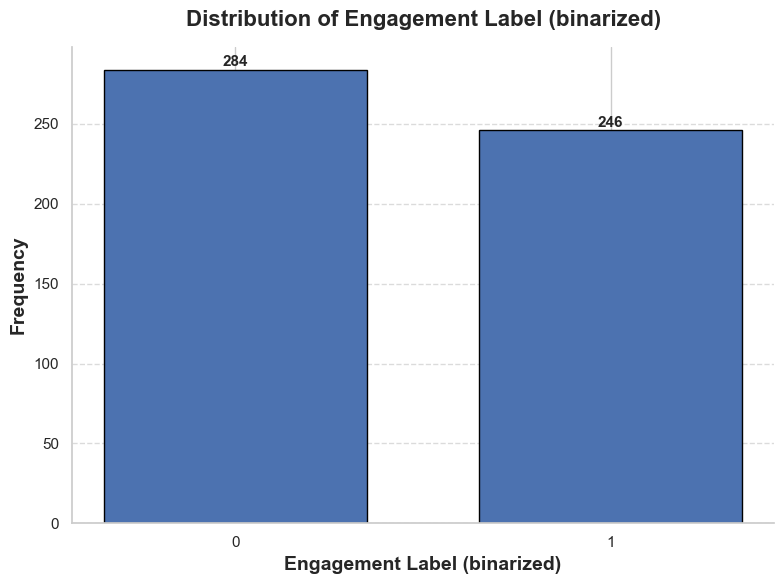

In [11]:
plot_categorical_distribution(
    engagement_labels_binary,
    label_name="Engagement Label (binarized)",
    use_latex=False,
)

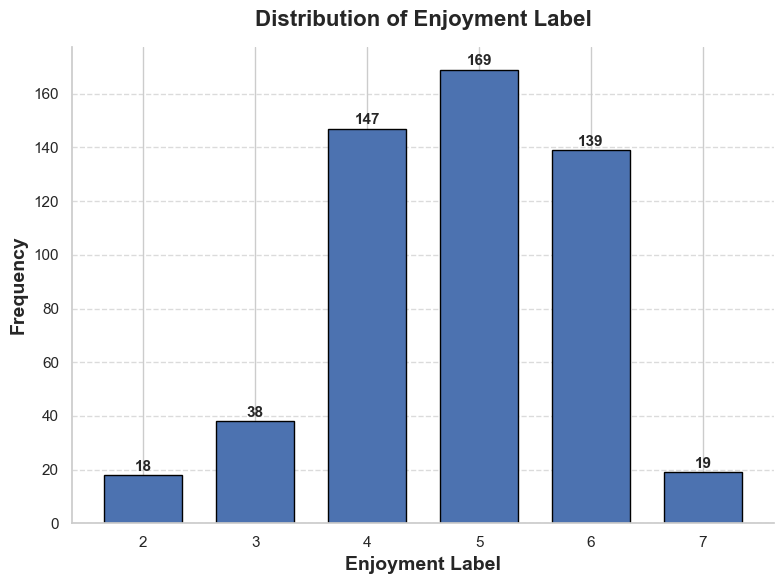

In [12]:
plot_categorical_distribution(
    enjoyment_labels,
    label_name="Enjoyment Label",
    use_latex=False,
)

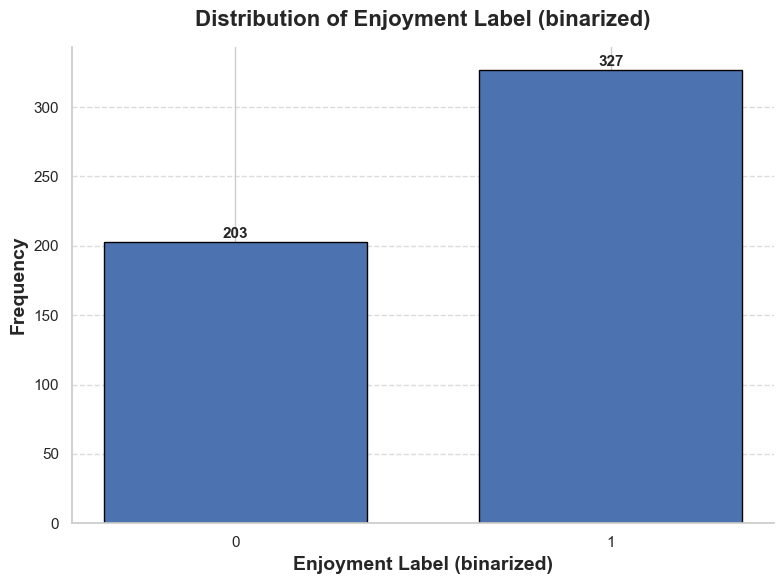

In [13]:
plot_categorical_distribution(
    enjoyment_labels_binary,
    label_name="Enjoyment Label (binarized)",
    use_latex=False,
)

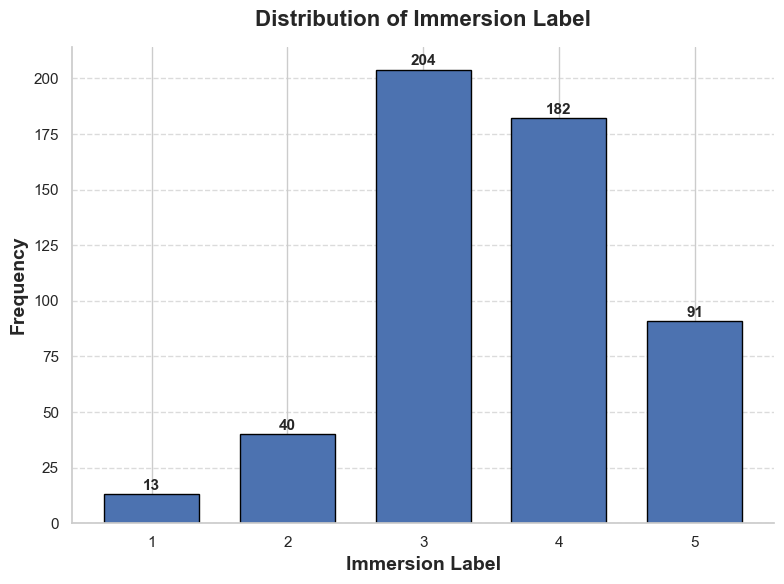

In [14]:
plot_categorical_distribution(
    immersion_labels,
    label_name="Immersion Label",
    use_latex=False,
)

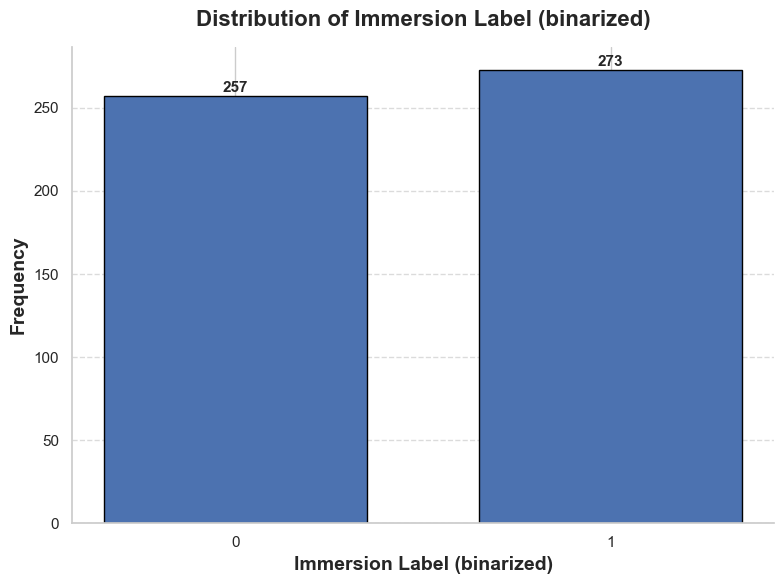

In [15]:
plot_categorical_distribution(
    immersion_labels_binary,
    label_name="Immersion Label (binarized)",
    use_latex=False,
)

In [ ]:
w

In [17]:
np.savez("../data.nosync/apsync/data_enjoyment_10sec.npz",
         values=segmented_data,
         labels=enjoyment_labels_binary,
         groups=groups,
         name='APSYNC (enjoyment)')

In [18]:
np.savez("../data.nosync/apsync/data_immersion_10sec.npz",
         values=segmented_data,
         labels=immersion_labels_binary,
         groups=groups,
         name='APSYNC (immersion)')